In [1]:
import logging
import sys

import numpy

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import matplotlib.pyplot as plt

from rascil.data_models import PolarisationFrame
from rascil.processing_components import create_blockvisibility_from_ms, \
    advise_wide_field, plot_uvcoverage, plot_visibility, weight_visibility,\
    create_image_from_visibility, show_image, export_image_to_fits

from rascil.processing_components.imaging.ng import invert_ng
from rascil.workflows.rsexecute.execution_support import rsexecute
from rascil.workflows.rsexecute.pipelines import continuum_imaging_list_rsexecute_workflow

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

Read the MeasurementSet

In [13]:
# bvis=create_blockvisibility_from_ms("CSRH_20151122-125000_100457483.ms",
#                                     start_chan=52,end_chan=52)[0]
bvis=create_blockvisibility_from_ms("/Users/wangfeng/Dropbox (SKA)/rascil_muser_test_data/selfmodel.ms",
                                    start_chan=52,end_chan=52)[0]

print(bvis)
advice=advise_wide_field(bvis, guard_band_image=0.5)
saved_flags = bvis.flags

create_blockvisibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_blockvisibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_blockvisibility_from_ms: Found 2770560 rows
create_blockvisibility_from_ms: Found 64 channels
create_blockvisibility_from_ms: Reading channels from 52 to 52
create_blockvisibility_from_ms: Observation from 2015-11-22 04:50:31.020 to 2015-11-22 04:51:59.995
BlockVisibility:
	Source SUN
	Phasecentre: <SkyCoord (ICRS): (ra, dec) in deg
    (237.3576405, -20.05175896)>
	Number of visibility blocks: 3552
	Number of integrations: 3552
	Visibility shape: (3552, 40, 40, 1, 2)
	Number of flags: 5825280
	Number of channels: 1
	Frequency: [1.7e+09]
	Channel bandwidth: [25000000.]
	Number of polarisations: 2
	Polarisation Frame: circularnp
	Configuration: 
	Metadata: {'MSV2': {'FIELD_ID': 0, 'DATA_DESC_ID': 0}}

advise_wide_field: (max_wavelength) 

Plot uv coverage and visibility before editing

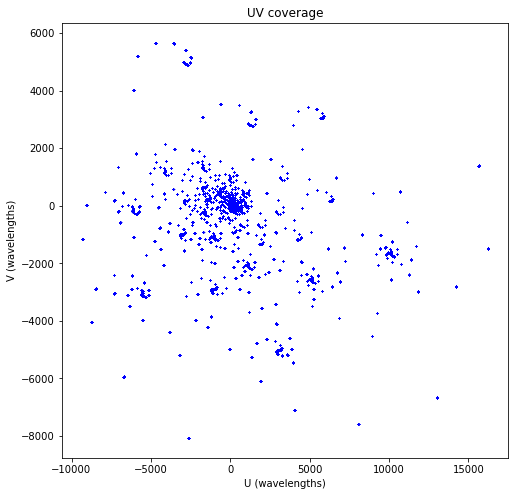

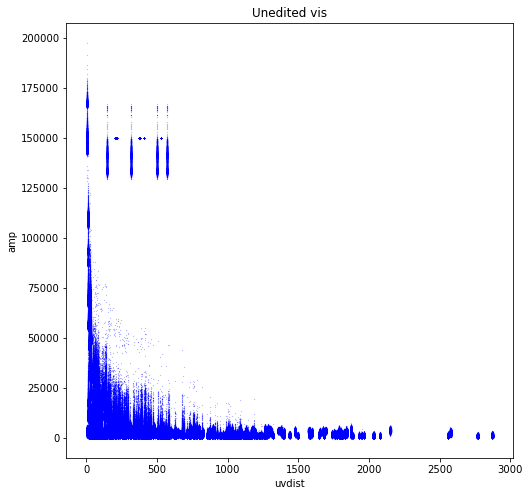

In [14]:
plot_uvcoverage([bvis], plot_file="CSRH_20151122-125000_100457483_uvcoverage.png")
plt.show()
plot_visibility([bvis], title="Unedited vis", plot_file="CSRH_20151122-125000_100457483_vis.png")
plt.show()

Used a simple clip to edit

In [15]:
print(numpy.sum(saved_flags))
bvis.data["flags"][...] = saved_flags
bad = numpy.abs(bvis.vis) > 2e5
print(numpy.sum(bad))
bvis.flags[...][bad] = 1

5825280
0


Now flag specific data

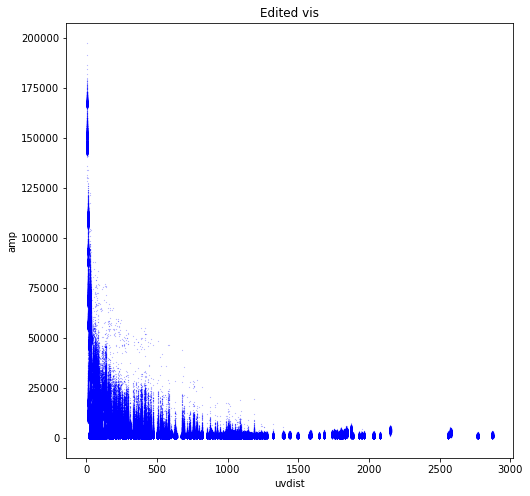

In [19]:
from rascil.processing_components.flagging.operations import flagging_blockvisibility, flagging_blockvisibility_with_bl

bvis = flagging_blockvisibility(bvis, antenna=[8, 9, 10, 11, 27])
baseline = [[4, 0], [4, 1], [5, 4], [21, 4], [24, 4], [25, 4], [26, 4], [27, 4], [28, 4], [29, 4], [30, 4], [31, 4],
            [32, 4], [36, 4], [38, 4], [39, 4]]
baseline.append([[17, 4], [17, 13], [19, 17], [26, 17], [27, 17], [28, 17], [29, 17], [30, 17], [31, 17], [39, 17]])
baseline.append([[19, 0], [19, 2], [19,3], [19, 5], [19, 6], [19, 8], [19, 9], [19, 10], [19, 11], [19, 17]])
baseline.append([[20, 19], [24, 19], [25,19], [26, 19], [27, 19], [28, 19], [29, 19], [30, 19], [31, 19], [34, 19],[36,19],[37,19],[39,19]])

for i in range(28):
    baseline.append([28,i])
baseline.append([[30, 28], [32, 28], [33,28], [34, 28], [35, 28], [36, 28], [37, 28], [38, 28], [39, 28]])

for i in range(28):
    baseline.append([29,i])
baseline.append([[32, 29], [33,29], [34, 29], [35, 29], [36, 29], [37, 29], [38, 29], [39, 29]])

for i in range(29):
    baseline.append([30,i])
baseline.append([[32, 30], [33,30], [34, 30], [35, 30], [36, 30], [37, 30], [38, 30], [39, 30]])
                 
bvis = flagging_blockvisibility_with_bl(bvis, baseline)
plot_visibility([bvis], title="Edited vis", plot_file="CSRH_20151122-125000_100457483_editedvis.png")
plt.show()

Make a template image which we use to direct subsequent processing

In [20]:
cellsize=advice["cellsize"]
model=create_image_from_visibility(bvis, cellsize=cellsize, npixel=1536, nchan=1,
                                   polarisation_frame=PolarisationFrame("stokesIV"))

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (237.3576405, -20.05175896)>, starting frequency 1700000000.0 Hz, and bandwidth 24999999.99975 Hz
create_image_from_visibility: uvmax = 16239.832201 wavelengths
create_image_from_visibility: Critical cellsize = 0.000031 radians, 0.001764 degrees
create_image_from_visibility: Cellsize          = 2.00721e-05 radians, 0.00115005 degrees
create_image_from_visibility: image shape is [1, 2, 1536, 1536]


Weight the data and calculate dirty image and PSF

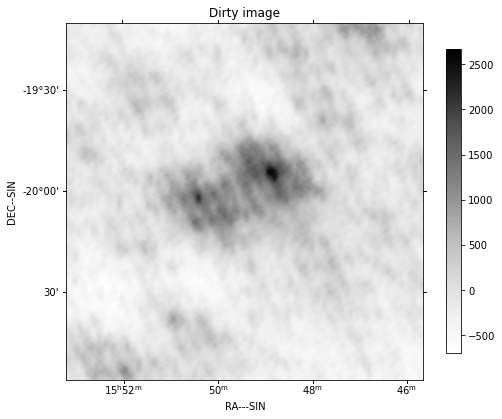

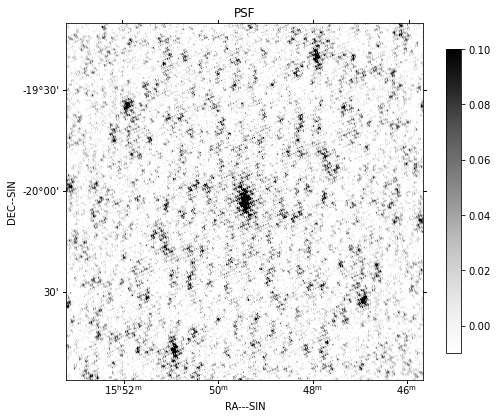

In [21]:
bvis = weight_visibility(bvis, model, weighting='robust')

dirty, sumwt = invert_ng(bvis, model, verbosity=1)
show_image(dirty, pol=0, title='Dirty image')
plt.savefig("CSRH_20151122-125000_100457483_dirty.png")
plt.show()

psf, sumwt = invert_ng(bvis, model, dopsf=True, verbosity=1)
show_image(psf, pol=0, title='PSF', vmax=0.1, vmin=-0.01)
plt.savefig("CSRH_20151122-125000_100457483_psf.png")
plt.show()

Now run the continuum imaging pipeline

calculate_image_frequency_moments: Reference frequency = 1700.000 (MHz)
threshold_list: using moment 0, sub_image 0, peak = 2667.405014,
threshold_list cip cycle 0: Global peak in moment 0 = 2667.405014, sub-image clean threshold will be 800.221504
calculate_image_frequency_moments: Reference frequency = 1700.000 (MHz)
deconvolve_cube cip cycle 0, subimage 0: Cleaning entire image
deconvolve_cube cip cycle 0, subimage 0: PSF support = +/- 512 pixels
deconvolve_cube cip cycle 0, subimage 0: PSF shape (1, 2, 1024, 1024)
deconvolve_cube cip cycle 0, subimage 0: Multi-scale clean of each polarisation and channel separately
deconvolve_cube cip cycle 0, subimage 0: Processing pol 0, channel 0
msclean cip cycle 0, subimage 0: Peak of PSF = 0.9999999999999915 at (512, 512)
msclean cip cycle 0, subimage 0: Peak of Dirty = 2667.405014 Jy/beam at (891, 873) 
msclean cip cycle 0, subimage 0: Coupling matrix =
 [[1.         0.7494725  0.41647877 0.18510013]
 [0.7494725  0.63709018 0.40609492 0.1844

msclean cip cycle 2, subimage 0: Max abs in dirty Image = 423.746612 Jy/beam
msclean cip cycle 2, subimage 0: Start of minor cycle
msclean cip cycle 2, subimage 0: This minor cycle will stop at 1000 iterations or peak < 127.123984 (Jy/beam)
msclean cip cycle 2, subimage 0: Timing for setup: 2.457 (s) for dirty shape (1536, 1536), PSF shape (1024, 1024) , scales [0, 10, 30, 100]
msclean cip cycle 2, subimage 0: Minor cycle 0, peak [-370.35112688 -367.61252222 -351.55627288 -289.83788929] at [178, 322, 3]
msclean cip cycle 2, subimage 0: Minor cycle 100, peak [158.00867652 159.6594103  168.34189921 169.71940092] at [943, 1155, 3]
msclean cip cycle 2, subimage 0: Minor cycle 200, peak [-176.87471799 -175.8961015  -168.27209018 -143.64541226] at [918, 1344, 3]
msclean cip cycle 2, subimage 0: Minor cycle 300, peak [183.34947184 182.09456871 174.42155019 127.34018395] at [656, 746, 3]
msclean cip cycle 2, subimage 0: At iteration 396, absolute value of peak 114.312478 is below stopping thre

msclean cip cycle 4, subimage 0: Coupling matrix =
 [[1.         0.7494725  0.41647877 0.18510013]
 [0.7494725  0.63709018 0.40609492 0.18441165]
 [0.41647877 0.40609492 0.3454279  0.17910823]
 [0.18510013 0.18441165 0.17910823 0.13686325]]
msclean cip cycle 4, subimage 0: Max abs in dirty Image = 147.127333 Jy/beam
msclean cip cycle 4, subimage 0: Start of minor cycle
msclean cip cycle 4, subimage 0: This minor cycle will stop at 1000 iterations or peak < 100.000000 (Jy/beam)
msclean cip cycle 4, subimage 0: Timing for setup: 2.235 (s) for dirty shape (1536, 1536), PSF shape (1024, 1024) , scales [0, 10, 30, 100]
msclean cip cycle 4, subimage 0: Minor cycle 0, peak [-112.87585748 -111.56750405 -109.34661092  -91.37017127] at [512, 821, 3]
msclean cip cycle 4, subimage 0: At iteration 1, absolute value of peak 87.482042 is below stopping threshold 100.000000
msclean cip cycle 4, subimage 0: End of minor cycle
msclean cip cycle 4, subimage 0: Timing for clean: 0.117 (s) for dirty shape 

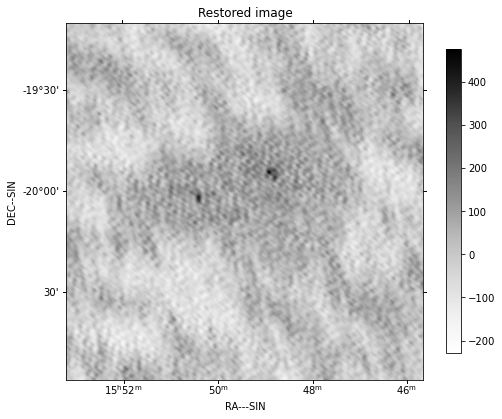

In [9]:
rsexecute.set_client(use_dask=False)

continuum_imaging_list = continuum_imaging_list_rsexecute_workflow([bvis],
                                                                   model_imagelist=[model],
                                                                   context='ng',
                                                                   scales=[0, 10, 30, 100],
                                                                   algorithm='msclean',
                                                                   niter=1000,
                                                                   fractional_threshold=0.3,
                                                                   threshold=100.0, nmajor=5, gain=0.1,
                                                                   psf_support=512,
                                                                   psfwidth=3.28)

result = rsexecute.compute(continuum_imaging_list, sync=True)

deconvolved = result[0][0]
residual = result[1][0]
restored = result[2][0]

show_image(restored, pol=0, title='Restored image')
plt.savefig("CSRH_20151122-125000_100457483_restored.png")
plt.show()

export_image_to_fits(deconvolved, "CSRH_20151122-125000_100457483_deconvolved.fits")
export_image_to_fits(restored, "CSRH_20151122-125000_100457483_restored.fits")
export_image_to_fits(residual[0], "CSRH_20151122-125000_100457483_residual.fits")